<a target="_blank" href="https://colab.research.google.com/github/evaalonsoortiz/ELE8812-demos/blob/main/Demos/Lesson%204/Le%C3%A7on_4_Demo_interp.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# ELE8812 - Traitement fréquentiel

## Démo :  Interpolation dans le domaine de Fourier : erreurs à ne pas faire

### Référence : DIP 4e édition, Chapitre 2, « IMAGE INTERPOLATION » p.77

Dans ce démo, une image de taille (M, N) sera sous-échantillonnée par un facteur de 0.5 pour obtenir une taille de (M/2, N/2) (diminution de la résolution) puis sur-échantillonnée par un facteur de 2 pour revenir à une taille de (M, N) (augmentation de la résolution) en utilisant 3 méthodes différentes : l’interpolation plus proche voisin (PPV), l’interpolation bilinéaire et l’interpolation dans le domaine spectral en utilisant la transformée de Fourier. L’image a été spécifiquement choisie pour accentuer les artéfacts d’interpolation par la présence de contenu à haute fréquence : les fines lignes parallèles sur les vêtements du sujet et les motifs de la chaise en arrière-plan.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy import signal

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# Option d'affichage
plt.rcParams['figure.figsize'] = (25,8)
plt.rcParams['axes.linewidth'] = 3
plt.rcParams['axes.titlesize'] = 15
plt.rcParams['axes.titlepad'] = 15
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [2]:
!git clone https://github.com/evaalonsoortiz/ELE8812-demos.git Repo

Mounted at /content/drive


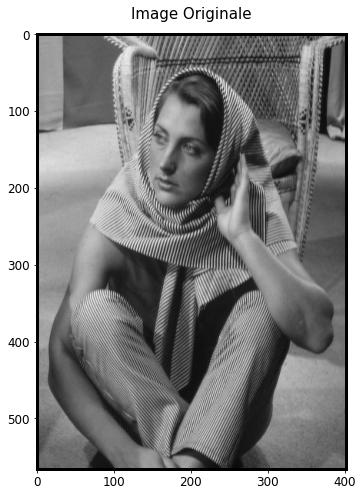

In [3]:
# Charger image
A = plt.imread('Repo/Data/Barbara.tif');
plt.subplot(121);
plt.imshow(A, cmap='gray'); plt.title('Image Originale'); plt.show();

Maximum des parties réelle et imaginaire de D :
Partie réelle 62.436999105892255  Partie imaginaire 0.3240929935328767


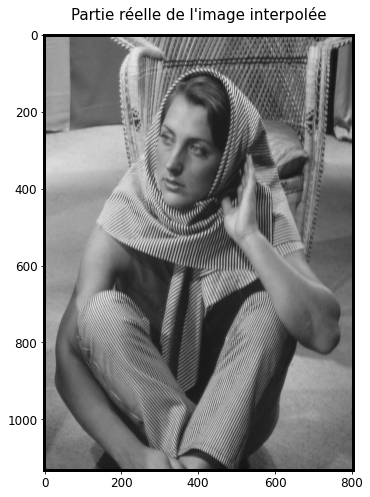

In [5]:
# Interpolation
B = np.fft.fftshift(np.fft.fft2(np.double(A)))

M, N = B.shape
M1 = 2*M
N1 = 2*N

C = np.zeros((M1, N1),dtype='complex128')
C[int(M/2):int(3*M/2), int(N/2):int(3*N/2)] = B

D = np.fft.ifft2(np.fft.ifftshift(C))

print('Maximum des parties réelle et imaginaire de D :')
print('Partie réelle', np.max(np.abs(np.real(D))), ' Partie imaginaire', np.max(np.abs(np.imag(D))))

plt.imshow(np.real(D), cmap='gray'); plt.title("Partie réelle de l'image interpolée"); plt.show();

In [34]:
def mae_ppv(im, sc):
    """ Interpolation par plus proche voisin d'une image im.
    im (nd.array): Image à interpoler.
    sc (float): Facteur d'échelle.
    
    Return:
        nd.array: Image interporlée.
    """
    
    M, N = im.shape

    # Nouvelles dimensions de l'image
    Ms, Ns = [int(np.round(M * sc)), int(np.round(N * sc))]
    
    ims = np.zeros((Ms,Ns))
    
    # étant donné qu'on considère un facteur d'échelle identique pour les deux dimensions, on peut seulement calculer le ratio de la position du nouveau pixel par rapport
    # au facteur d'échelle
    
    for i in range(Ms):
        for j in range(Ns):
            ii = int(np.round(i / sc))
            jj = int(np.round(j / sc))
            ims[i,j] = im[ii,jj]
    return ims

def mae_bil(im, sc):
    """ Interpolation bilinéaire d'une image im.
    im (nd.array): Image à interpoler.
    sc (float): Facteur d'échelle.
    
    Return:
        nd.array: Image interporlée.
    """
    
    if sc <= 0 :
        display('scale : le parametre d echelle doit etre > 0')
        return
    

    if np.ndim(im) != 2 :
        display('Image doit avoir 2 dimensions')
        return

    M, N = im.shape

    # Nouvelles dimensions de l'image
    Ms, Ns = [round(M * sc), round(N * sc)]

    xs = np.linspace(1, Ms, Ms)
    ys = np.linspace(1, Ns, Ns)

    xsp = xs * M / Ms
    ysp = ys * N / Ns
    
    # Ajouter un pixel autour car il faut interpoler les pixels sur les bords
    Ap = np.pad(im, 1, 'symmetric')
    
    # Extraire les nouvelles coordonnées de l'image
    xisp = np.floor(xs * M / Ms).astype(int)
    yisp = np.floor(ys * N / Ns).astype(int)
    
    [Xsp, Ysp] = np.meshgrid(xsp,ysp)
    Xsp = np.transpose(Xsp)
    Ysp = np.transpose(Ysp)

    Xfsp = Xsp - np.floor(Xsp) # Coefficients pour l'interpolation
    Yfsp = Ysp - np.floor(Ysp)  

    # Interpolation bilinéaire
    ims = (1 - Xfsp) * (1 - Yfsp) * Ap[xisp, :][:, yisp] + \
          Xfsp * (1-Yfsp) * Ap[xisp + 1, :][:, yisp] + \
          (1 - Xfsp) * Yfsp * Ap[xisp, :][:, yisp + 1] + \
          Xfsp * Yfsp * Ap[xisp + 1, :][:, yisp + 1]
    return ims

def mae_freq(im, sc):
    """ Interpolation dans le domaine fréquentiel.
    im (nd.array): Image à interpoler.
    sc (float): Facteur d'échelle.
    
    Return:
        nd.array: Image interporlée.
    """
    A = im
    M, N = A.shape
    
    Ms = round(M*sc) # Taille de l'image 
    Ns = round(N*sc) # mise à l'échelle ims

    AA = np.fft.fftshift(np.fft.fft2(A))

    if sc > 1:
        # Zero Padding Sizes
        left = np.ceil((sc - 1) * N / 2).astype(int)
        right = np.floor((sc - 1) * N / 2).astype(int)
        top = np.ceil((sc - 1) * M / 2).astype(int)
        bottom = np.floor((sc - 1) * M / 2).astype(int)

        # Pad Fourier Transform
        BB = np.pad(AA, [(top, bottom), (left, right)], 'constant', constant_values=0+0j)

    else: 
        # Center Crop Fourier Transform      
        BB = AA[int(M/2-Ms/2)+1:int(M/2+Ms/2)+1,int(N/2-Ns/2)+1:int(N/2+Ns/2)+1]

    # Inverse Fourier Transform
    out = np.real(np.fft.ifft2(np.fft.ifftshift(BB)))

    # To preserve the values of the original samples, the L2 norm has to be multiplied by sc*sc.
    out*=sc**2        

    return out[0:Ms,0:Ns]

## Interpolation bilinéaire, plus proche voisin et spectrale

Une façon de visualiser l’interpolation dans le domaine spatial consiste à imaginer une grille de pixels ayant la nouvelle dimension voulu avec des pixel de même taille que ceux de l’image originale. Cette grille peut ensuite être élargie (dans le cas d’un sous-échantillonnage) ou rétrécie (dans le cas d’un sur-échantillonnage) pour que ses contours soient parfaitement superposés à ceux de l’image originale. Ensuite, des valeurs sont assignées aux pixels de l’image redimensionnée selon la méthode utilisée.

Pour l’interpolation PPV, pour chaque pixel de la nouvelle grille, la valeur du pixel le plus proche sur l’image de dessous est assignée. La position exacte d’un pixel peut être définie en tant que la position d’un de ses coins (e.g. le coin inférieur droit). Cette méthode d’interpolation entraîne d’importants artéfacts : les lignes droites sont distortionnées.


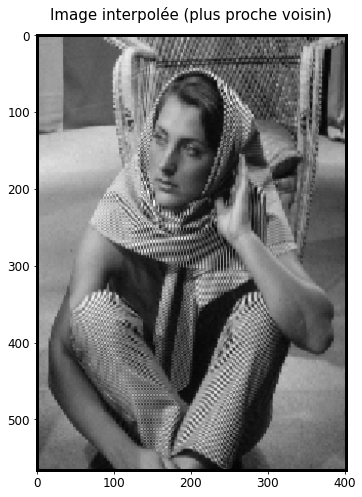

In [35]:
# Plus proche voisin
B = mae_ppv(mae_ppv(A, 0.5), 2)

plt.imshow(np.real(B),cmap='gray'); plt.title('Image interpolée (plus proche voisin)'); plt.show()

Pour l’interpolation bilinéaire, la valeur du nouveau pixel correspond à une combinaison linéaire des 4 pixels les plus proches sur l’image de dessous (image initiale). Cette méthode donne un meilleur résultat que l’interpolation PPV pour un coût computationnel légèrement plus élevé.

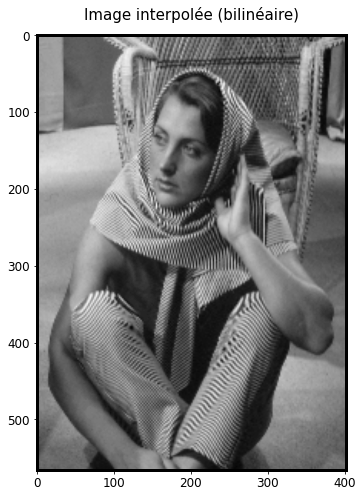

In [36]:
# Bilinéaire
C = mae_bil(mae_bil(A, 0.5), 2)

plt.imshow(np.real(C),cmap='gray'); plt.title('Image interpolée (bilinéaire)'); plt.show()

L’interpolation peut aussi être réalisée dans le domaine fréquentiel. Pour effectuer un sous-échantillonnage par un facteur de 0.5, une fois la transformée de Fourier (TF) de l’image obtenue, on conserve uniquement un rectangle de taille (M/2, N/2) centré à la fréquence (0,0). En effectuant une TF inverse, on obtient ainsi une image de taille (M/2, N/2). Pour effectuer un sur-échantillonnage par un facteur de 2, la TF de l’image sous-échantillonnée de taille (M/2, N/2) est bourrée de zéros en bordure pour obtenir une taille de (M, N). Une TF inverse est ensuite réalisée pour obtenir l’image interpolée. À noter que pour conserver l’échelle des valeurs de l’image originale, le résultat doit être multiplié par le carré du facteur de sous- ou sur-échantillonnage. Cette méthode donne un meilleur résultat que les 2 méthodes d’interpolation effectuée dans le domaine spatial.

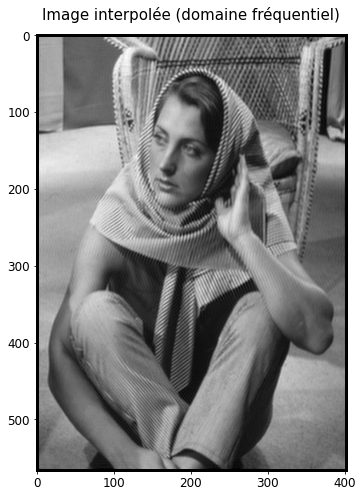

In [37]:
# Spectral
D = mae_freq(mae_freq(A, 0.5),2)
plt.imshow(np.real(D),cmap='gray'); plt.title('Image interpolée (domaine fréquentiel)'); plt.show()